In [1]:
import os
import sys
import yaml

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

dname = os.path.abspath('')
module_dir = os.path.abspath("{}/../deeplio".format(dname))
content_dir = os.path.abspath("{}/..".format(dname))
sys.path.append(dname)
sys.path.append(module_dir)
sys.path.append(content_dir)

from deeplio.datasets import KittiRawData


CONFIG_PATH = "{}/config.yaml".format(content_dir)
with open(CONFIG_PATH) as f:
    cfg = yaml.safe_load(f)
    
# extracting infos from config file
ds_cfg = cfg['datasets']
kitti_config = ds_cfg['kitti']
seq_size = ds_cfg['sequence-size']
root_path = kitti_config['root-path']

ds_type = "train"

batch_size = 1
num_workers = 6

# visualizing Raw Images

In [4]:
CHANNEL_NAMES = ['x', 'y', 'z', 'depth', 'remission']

num_channels = len(CHANNEL_NAMES)

datasets = []
for date, drives in kitti_config[ds_type].items():
    for drive in drives:
        date = str(date).replace('-', '_')
        drive = '{0:04d}'.format(drive)
        datasets.append(KittiRawData(root_path, date, drive, ds_cfg))
        print("reading datset {}".format(datasets[-1].data_path))


reading datset /media/ajava/Data/Datasets/KITTI/2011_10_03/2011_10_03_drive_0027_extract
reading datset /media/ajava/Data/Datasets/KITTI/2011_10_03/2011_10_03_drive_0042_extract
reading datset /media/ajava/Data/Datasets/KITTI/2011_10_03/2011_10_03_drive_0034_extract
reading datset /media/ajava/Data/Datasets/KITTI/2011_09_30/2011_09_30_drive_0016_extract
reading datset /media/ajava/Data/Datasets/KITTI/2011_09_30/2011_09_30_drive_0018_extract
reading datset /media/ajava/Data/Datasets/KITTI/2011_09_30/2011_09_30_drive_0020_extract
reading datset /media/ajava/Data/Datasets/KITTI/2011_09_30/2011_09_30_drive_0027_extract


reading one image sample (index=129) from /media/ajava/Data/Datasets/KITTI/2011_09_30/2011_09_30_drive_0027_extract.
image shape:  (64, 1800, 5)


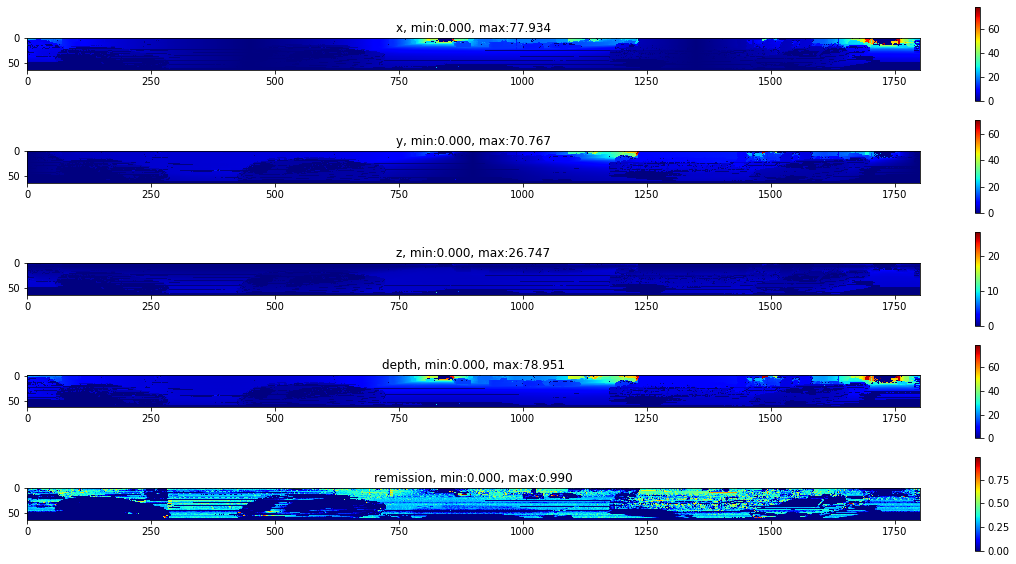

In [5]:
ds_idx = np.random.randint(0, len(datasets))
im_idx = np.random.randint(0, len(datasets[ds_idx]))

dataset = datasets[ds_idx] 
print("reading one image sample (index={}) from {}.".format(im_idx, dataset.data_path))

# get an sample image
im = dataset.get_velo_image(im_idx)

# convert negativ x, y, z coord. to postive
im = np.abs(im)

print("image shape: ", im.shape)

viridis = cm.get_cmap('viridis', 512)
gray = cm.get_cmap('gray', 1024)
jet = cm.get_cmap('jet', 1024)
CHANNEL_CMAP = [jet, jet, jet, jet, jet, gray]

fig, axes = plt.subplots(num_channels, 1, figsize=(20, 10))
for i in range(num_channels):
    ax = axes[i]
    img = im[:, :, i]
    ax.imshow(img, cmap=CHANNEL_CMAP[i])
    ax.set_title("{}, min:{:.3f}, max:{:.3f}".format(CHANNEL_NAMES[i], img.min(), img.max()))
    psm = ax.pcolormesh(img, cmap=CHANNEL_CMAP[i], rasterized=True, vmin=img.min(), vmax=img.max())
    fig.colorbar(psm, ax=ax)

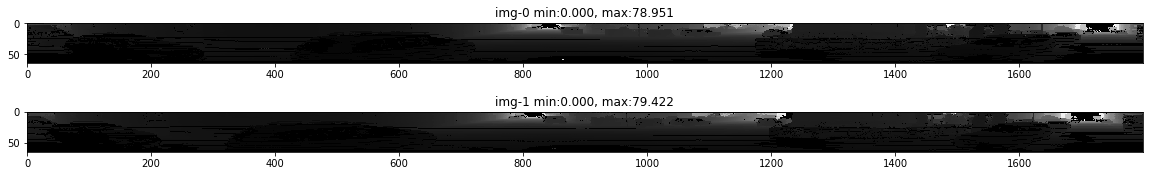

In [6]:
# get an sample image
im_0 = dataset.get_velo_image(im_idx)
# get an sample image
im_1 = dataset.get_velo_image(im_idx+2)


imgs = [im_0, im_1]
fig, axes = plt.subplots(2, 1, figsize=(20, 3))
for i in range(2):
    ax = axes[i]
    img = imgs[i][:, :, 3]
    ax.imshow(img, cmap='gray')
    ax.set_title("img-{} min:{:.3f}, max:{:.3f}".format(i, img.min(), img.max()))


# Visualizing Image Gradients

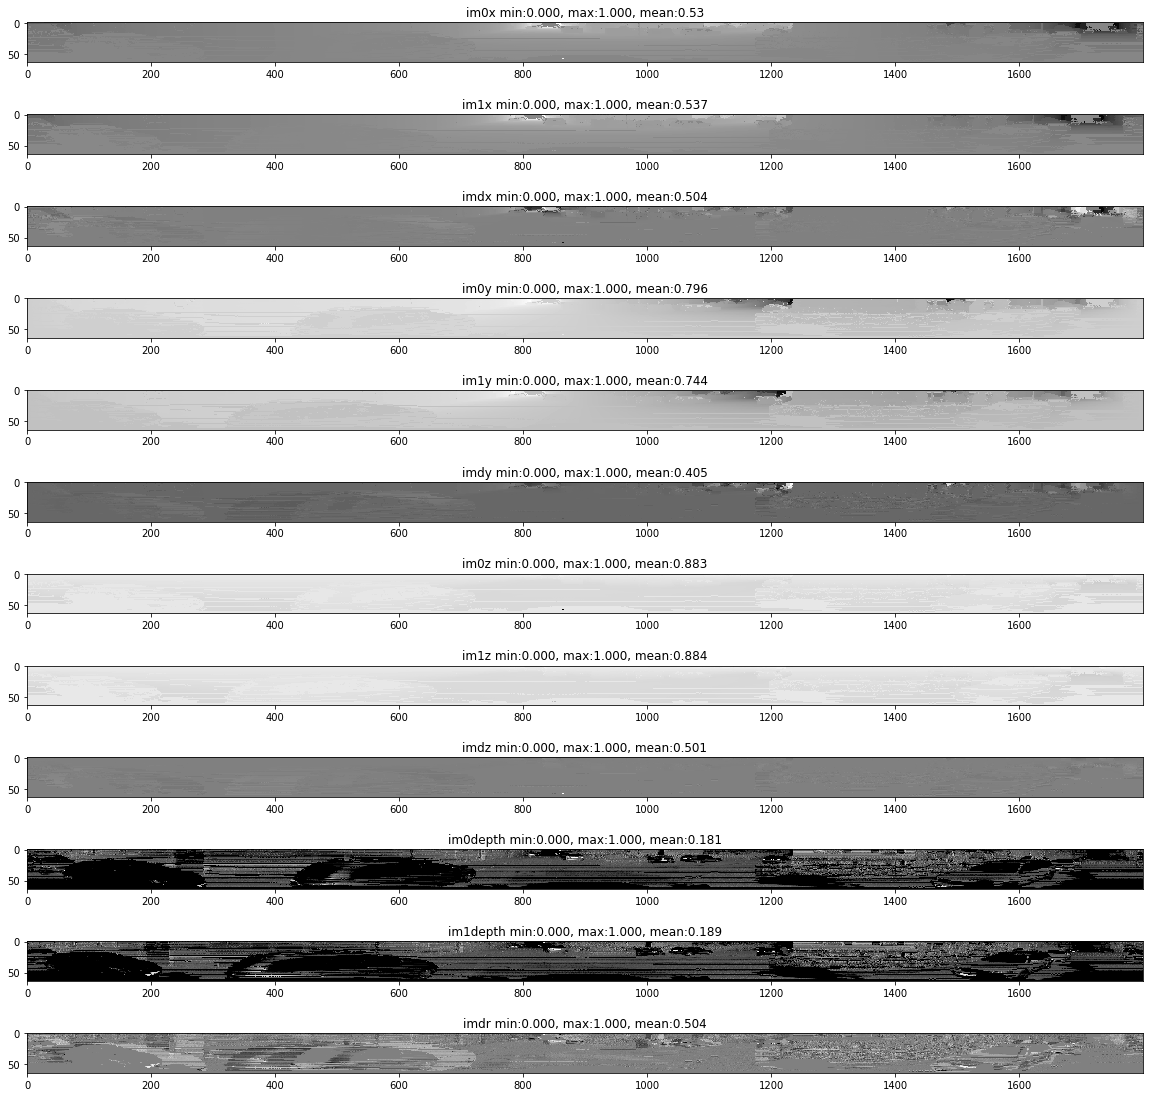

In [7]:
def normalize_image(im):
    return (im - im.min()) / (im.max() - im.min())

im0x = im_0[:, :, 0]
im0y = im_0[:, :, 1]
im0z = im_0[:, :, 2]
im0depth = im_0[:, :, 4]

im1x = im_1[:, :, 0]
im1y = im_1[:, :, 1]
im1z = im_1[:, :, 2]
im1depth = im_1[:, :, 4]

im_dx = im1x - im0x
im_dy = im1y - im0y
im_dz = im1z - im0z
im_dr = im1depth - im0depth

imgs = {'im0x': im0x, 'im1x': im1x, 'imdx': im_dx, 'im0y': im0y, 'im1y':im1y, 
        'imdy': im_dy, 'im0z': im0z, 'im1z': im1z, 'imdz': im_dz, 'im0depth': 
        im0depth, 'im1depth': im1depth, 'imdr': im_dr}

fig, axes = plt.subplots(len(imgs), 1, figsize=(20, 20))
for i, (k, img) in enumerate(imgs.items()):
    ax = axes[i]
    img = normalize_image(img)
    ax.imshow(img, cmap='gray')
    ax.set_title("{} min:{:.3f}, max:{:.3f}, mean:{:.3}".format(k, img.min(), img.max(), img.mean()))

# Reading and Saving Normalized Images from Dataset-Loader 

In [2]:
import logging
import datetime
from pathlib import Path

import torch.utils.data
import torch.nn.functional as F

from deeplio.common.logger import PyLogger, get_app_logger
from deeplio.datasets import Kitti, deeplio_collate

OUTPUT_PATH = "{}/outputs/images".format(content_dir)

# create directoy to save images
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# max. number of image swe want to save
max_num_it = -1

# Dataset class needs a global logger, so creat it here
# TODO: Remove dependecy of dataset to global logger, so it can have its own
flog_name = "{}/{}_{}.log".format(OUTPUT_PATH, "Dataset-Visualization", datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
get_app_logger(filename=flog_name, level=logging.INFO)
    
# create dataset andataloader
kitti_dataset = Kitti(config=cfg, transform=None, ds_type='train')
dataloader = torch.utils.data.DataLoader(kitti_dataset, batch_size=batch_size,
                                       num_workers=num_workers,
                                       shuffle=False,
                                       collate_fn = deeplio_collate)

print("Length of dataset is {}".format(len(dataloader)))

Length of dataset is 15659


  4%|▍         | 677/15659 [02:53<1:01:18,  4.07it/s]

SystemError: <built-in method write of _io.BufferedWriter object at 0x7f9da188d1d0> returned a result with an error set

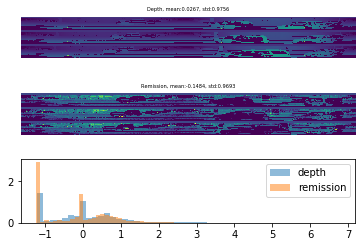

In [3]:
from tqdm import tqdm

pbar = tqdm(total=len(dataloader))
        
# Iterate through datset and save images
for idx, data in enumerate(dataloader):
    # skip invalid data without ground-truth
    if not torch.all(data['valid']):
        pbar.update(1)
        #print("[{}] Invalid!".format(idx))
        continue
        
    metas = data['metas'][0]
    index = metas['index'][0]
    date = metas['date'][0]
    drive = metas['drive'][0]
    
    ims = data['images'].detach().cpu()
    for b in range(len(ims)):
        ims_batch = ims[b]
        ims_depth = [F.pad(im, (0, 0, 10, 0)) for im in ims_batch[:, 0, :, :]]
        ims_depth = torch.cat(ims_depth, dim=0)

        ims_remission = [F.pad(im, (0, 0, 10, 0)) for im in ims_batch[:, 1, :, :]]
        ims_remission = torch.cat(ims_remission, dim=0)

        fig, ax = plt.subplots(3, 1)
        ax[0].set_title("Depth, mean:{:.4f}, std:{:.4f}".format(ims_depth.mean(), ims_depth.std()), fontsize=5)
        ax[0].axis('off')
        ax[0].imshow(ims_depth)

        ax[1].set_title("Remission, mean:{:.4f}, std:{:.4f}".format(ims_remission.mean(), ims_remission.std()), fontsize=5)
        ax[1].imshow(ims_remission)
        ax[1].axis('off')

        ax[2].hist(ims_depth.flatten(), bins=50, alpha=0.5, label="depth", density=True)
        ax[2].hist(ims_remission.flatten(), bins=50, alpha=0.5, label="remission", density=True)
        ax[2].legend()
        
        fname = "{}/{}_{}_{}.png".format(OUTPUT_PATH, index, date, drive)
        #print("[{}] Saving {}".format(idx, fname))        
        fig.savefig(fname, dpi=300)
        plt.close(fig)
    
    pbar.update(1)
    if max_num_it > 0 and idx > max_num_it:
        break

# Average Transformation of the Kitti Dataset 

In [2]:
import logging
import datetime
from pathlib import Path

import torch.utils.data
import torch.nn.functional as F

from deeplio.common.logger import PyLogger, get_app_logger
from deeplio.datasets import Kitti, deeplio_collate
from deeplio.models.misc import PostProcessSiameseData  

OUTPUT_PATH = "{}/outputs/kittt_avg_trans".format(content_dir)

# create directoy to save images
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Dataset class needs a global logger, so creat it here
# TODO: Remove dependecy of dataset to global logger, so it can have its own
flog_name = "{}/{}_{}.log".format(OUTPUT_PATH, "Kitt-Avg-Trans", datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
get_app_logger(filename=flog_name, level=logging.INFO)
    
# create dataset andataloader
kitti_dataset = Kitti(config=cfg, transform=None, ds_type='train')
dataloader = torch.utils.data.DataLoader(kitti_dataset, batch_size=batch_size,
                                       num_workers=num_workers,
                                       shuffle=True,
                                       collate_fn = deeplio_collate)

post_processor = PostProcessSiameseData(seq_size=seq_size, batch_size=batch_size, shuffle=True)

print("Length of dataset is {}".format(len(dataloader)))

Length of dataset is 15659


In [3]:
from deeplio.common.spatial import rotation_matrix_to_quaternion, quaternion_to_angle_axis

from tqdm import tqdm

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

pbar = tqdm(total=len(dataloader))

x_avg = AverageMeter('x')
q_avg = AverageMeter('q')

# Iterate through datset and save images
for idx, data in enumerate(dataloader):
    # skip invalid data without ground-truth
    if not torch.all(data['valid']):
        pbar.update(1)
        #print("[{}] Invalid!".format(idx))
        continue
        
    metas = data['metas'][0]
    index = metas['index'][0]
    date = metas['date'][0]
    drive = metas['drive'][0]

    imgs_0, imgs_1,  imgs_untrans_0, imgs_untrans_1, gts, imus = post_processor(data)
    
    # prepare ground truth tranlational and rotational part
    gt_pos = gts[:, :3, 3].contiguous()
    gt_rot = rotation_matrix_to_quaternion(gts[:, :3, :3].contiguous())
    
    x_avg.update(gt_pos.mean(dim=0).numpy()) 
    q_avg.update(gt_rot.mean(dim=0).numpy())    
    
    pbar.update(1)
    #if idx % 100 == 0:
    #    print("{} x-avg: {}, q-avg: {}".format(idx, x_avg.avg, q_avg.avg))
print("x-avg: {}, q-avg: {}".format(x_avg.avg, q_avg.avg))


100%|█████████▉| 15652/15659 [04:47<00:00, 55.36it/s]

x-avg: [1.4350199e+00 6.2639872e-04 1.3253570e-02], q-avg: [-6.2973281e-06  5.3813543e-05  3.3050732e-04  9.9992609e-01]


100%|██████████| 15659/15659 [05:00<00:00, 55.36it/s]